# Chapter 7: Pretrained Models in TIMM and HuggingFace

In [ ]:
!pip install transformers timm

In [ ]:
!wget https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/helper_functions.py

In [ ]:
from helper_functions import get_image_from_url

## 7.3 PyTorch Image Models (TIMM)

In [30]:
import timm
import torch
from torchvision.transforms import ToPILImage

timm_models = timm.list_models(pretrained=True)
len(timm_models)

1163

### 7.3.1 Model

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [31]:
model = timm.create_model('mobilevit_xxs', pretrained=True)
model

ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (shortcut): Identity()
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
          

### 7.3.2 Metadata

In [32]:
model_cfg = model.pretrained_cfg
model_cfg

{'url': '',
 'hf_hub_id': 'timm/mobilevit_xxs.cvnets_in1k',
 'architecture': 'mobilevit_xxs',
 'tag': 'cvnets_in1k',
 'custom_load': False,
 'input_size': (3, 256, 256),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.9,
 'crop_mode': 'center',
 'mean': (0.0, 0.0, 0.0),
 'std': (1.0, 1.0, 1.0),
 'num_classes': 1000,
 'pool_size': (8, 8),
 'first_conv': 'stem.conv',
 'classifier': 'head.fc'}

### 7.3.3 Transforms

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step3.png)

In [33]:
transform_cfg = timm.data.resolve_data_config(model_cfg)
transform_cfg

{'input_size': (3, 256, 256),
 'interpolation': 'bicubic',
 'mean': (0.0, 0.0, 0.0),
 'std': (1.0, 1.0, 1.0),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [34]:
transforms_fn = timm.data.create_transform(**transform_cfg)
transforms_fn

Compose(
    Resize(size=284, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=tensor([0., 0., 0.]), std=tensor([1., 1., 1.]))
)

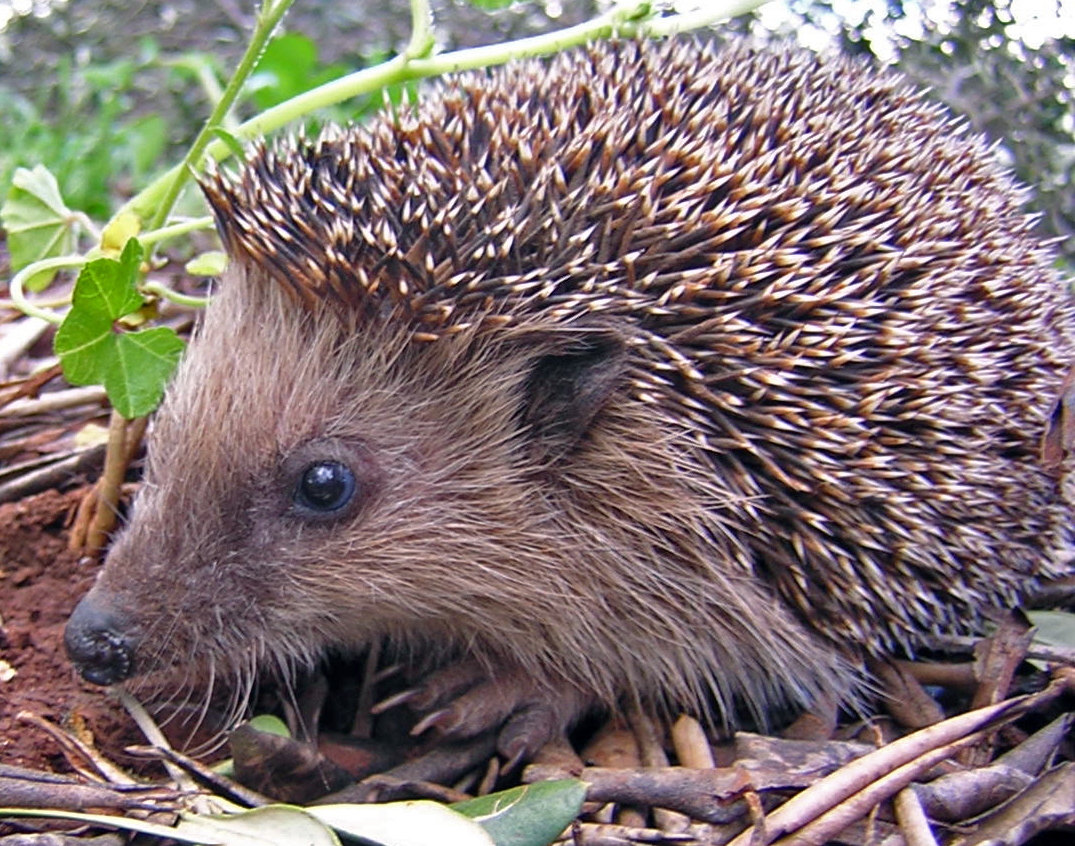

In [35]:
url = 'https://upload.wikimedia.org/wikipedia/commons/7/72/Igel.JPG'
headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
img = get_image_from_url(url, headers)
img

In [36]:
preproc_img = transforms_fn(img)
preproc_img.shape

torch.Size([3, 256, 256])

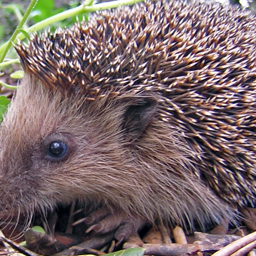

In [39]:
ToPILImage()(preproc_img)

### 7.3.4 Inference

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

In [40]:
import requests
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')

In [ ]:
from PIL import Image

def predict(path_or_url, model, transforms_fn, categories, topk=1, headers=None):
    if path_or_url.startswith('http'):
        img = get_image_from_url(path_or_url, headers=headers)
    else:
        img = Image.open(path_or_url)
        
    preproc_img = transforms_fn(img)
    if len(preproc_img.shape) == 3:
        preproc_img = preproc_img.unsqueeze(0)
    
    model.eval()
    device = next(iter(model.parameters())).device
    pred = model(preproc_img)
        
    probabilities = torch.nn.functional.softmax(pred[0], dim=0)
    values, indices = torch.topk(probabilities, topk)
    
    return [{'label': categories[i], 'value': v.item()} for i, v in zip(indices, values)]

In [41]:
predict(url, model, transforms_fn, IMAGENET_1k_LABELS, topk=3)

[{'label': 'porcupine, hedgehog', 'value': 0.9360215067863464},
 {'label': 'echidna, spiny_anteater, anteater', 'value': 0.019951535388827324},
 {'label': 'limpkin, Aramus_pictus', 'value': 0.0019446961814537644}]

### 7.3.5 Feature Extraction

In [42]:
features = model.forward_features(preproc_img.unsqueeze(0))
features.shape

torch.Size([1, 320, 8, 8])

## 7.4 HuggingFace

### 7.4.3 Model

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [44]:
from transformers import AutoModelForImageClassification

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch5/hf_model_tasks.png)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch5/hf_model_image_cls.png)

In [45]:
model_name = 'google/vit-base-patch16-224'
model = AutoModelForImageClassification.from_pretrained(model_name)

### 7.4.4 Metadata

In [46]:
dir(model.config)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_class',
 '_commit_hash',
 '_create_repo',
 '_dict_from_json_file',
 '_get_config_dict',
 '_get_files_timestamps',
 '_name_or_path',
 '_upload_modified_files',
 'add_cross_attention',
 'architectures',
 'attention_probs_dropout_prob',
 'attribute_map',
 'bad_words_ids',
 'begin_suppress_tokens',
 'bos_token_id',
 'chunk_size_feed_forward',
 'cross_attention_hidden_size',
 'decoder_start_token_id',
 'dict_torch_dtype_to_str',
 'diversity_penalty',
 'do_sample',
 'early_stopping',
 'encoder_no_repeat_ngram_size',
 'encoder_stride',
 'eos_token_id',
 'exponential_decay_length_penalty',
 'finetuning_

In [47]:
labels = model.config.id2label
categories = list(labels.values())

### 7.4.5 Transforms

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step3.png)

In [48]:
from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained(model_name)
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [49]:
url = 'https://upload.wikimedia.org/wikipedia/commons/7/72/Igel.JPG'
headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
img = get_image_from_url(url, headers)

In [50]:
processor(img)

{'pixel_values': [array([[[ 0.6784314 ,  0.67058825,  0.79607844, ...,  0.84313726,
          0.9843137 ,  0.99215686],
        [ 0.9137255 ,  0.8666667 ,  0.85882354, ...,  0.77254903,
          0.99215686,  0.99215686],
        [ 0.99215686,  0.9843137 ,  0.8745098 , ...,  0.9372549 ,
          0.9843137 ,  0.99215686],
        ...,
        [-0.29411763,  0.082353  ,  0.36470592, ..., -0.99215686,
         -1.        , -1.        ],
        [ 0.4431373 ,  0.33333337,  0.22352946, ..., -1.        ,
         -1.        , -0.99215686],
        [ 0.35686278,  0.20000005,  0.19215691, ..., -1.        ,
         -0.99215686, -0.99215686]],

       [[ 0.70980394,  0.6862745 ,  0.8039216 , ...,  0.8509804 ,
          0.99215686,  0.99215686],
        [ 0.9137255 ,  0.8745098 ,  0.8666667 , ...,  0.78039217,
          0.99215686,  0.99215686],
        [ 0.99215686,  0.9843137 ,  0.8745098 , ...,  0.9372549 ,
          0.9843137 ,  0.99215686],
        ...,
        [-0.4823529 , -0.08235294,  

In [51]:
def build_transforms_fn(processor):
    def transforms_fn(img):
        return processor.preprocess(img, return_tensors='pt')['pixel_values']
    return transforms_fn

transforms_fn = build_transforms_fn(processor)

In [52]:
preproc_img = transforms_fn(img)
preproc_img.shape

torch.Size([1, 3, 224, 224])

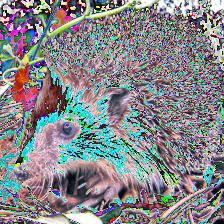

In [53]:
ToPILImage()(preproc_img[0])

### 7.4.6 Inference

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

In [54]:
model.eval()
pred = model(preproc_img)
isinstance(pred, dict), pred

(True,
 ImageClassifierOutput(loss=None, logits=tensor([[-5.2828e-01, -1.9690e-01,  1.7011e-01, -1.1577e+00,  1.2764e-01,
           1.5199e+00, -8.2261e-02, -7.6578e-01, -5.8229e-01,  1.6382e-01,
          -5.8190e-02, -6.5383e-01, -5.7106e-01, -1.0750e+00, -5.2697e-02,
          -3.2867e-01, -5.4519e-01,  1.7482e-01,  7.8771e-01, -7.9023e-01,
           3.8849e-01,  7.3125e-01,  9.5177e-02, -8.5252e-02, -2.1558e-01,
           2.7923e-01,  1.7429e-01, -7.7838e-02, -5.9353e-02,  6.4259e-01,
          -7.3161e-01,  5.2128e-01,  1.2292e+00, -5.5364e-01,  6.6180e-01,
           8.0318e-01,  4.9903e-01,  1.3128e+00,  1.4090e+00, -5.6347e-01,
          -3.4607e-01,  1.3534e-01,  6.8190e-01,  1.3080e-01,  1.3090e-01,
           1.2250e+00,  4.7738e-01,  9.0579e-01, -1.9106e-01, -2.2675e-01,
           5.3929e-01,  3.6598e-01,  3.8111e-01,  6.6180e-01,  5.0082e-01,
           2.8769e-01,  1.4384e+00, -4.9748e-01, -1.7561e-01, -2.2807e-01,
           1.5468e+00,  8.4968e-01, -2.8348e-01, -3.9

In [55]:
def predict(path_or_url, model, transforms_fn, categories, topk=1, headers=None):
    if path_or_url.startswith('http'):
        img = get_image_from_url(path_or_url, headers=headers)
    else:
        img = Image.open(path_or_url)
        
    preproc_img = transforms_fn(img)
    if len(preproc_img.shape) == 3:
        preproc_img = preproc_img.unsqueeze(0)
    
    model.eval()
    device = next(iter(model.parameters())).device    
    pred = model(preproc_img)
    
    # If the output is a dictionary, extract logits from it
    if isinstance(pred, dict):
        pred = pred['logits']
        
    probabilities = torch.nn.functional.softmax(pred[0], dim=0)
    values, indices = torch.topk(probabilities, topk)
    
    return [{'label': categories[i], 'value': v.item()} for i, v in zip(indices, values)]

In [56]:
predict(url, model, transforms_fn, categories, topk=5)

[{'label': 'porcupine, hedgehog', 'value': 0.9820719361305237},
 {'label': 'echidna, spiny anteater, anteater', 'value': 0.001100568100810051},
 {'label': 'microphone, mike', 'value': 0.0005925498553551733},
 {'label': 'beaver', 'value': 0.0005919974064454436},
 {'label': 'badger', 'value': 0.0003148827818222344}]

### 7.4.7 Pipelines

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch5/hf_cv_tasks.png)

In [57]:
from transformers import pipeline
classifier = pipeline(task='image-classification')

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch5/hedgehog.jpg)

Source: [Hedgehog](https://pixabay.com/photos/hedgehog-child-young-hedgehog-1759006/) by [Alexas_Fotos](https://pixabay.com/users/alexas_fotos-686414/)

In [ ]:
!wget https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch5/hedgehog.jpg

In [58]:
fname = './hedgehog.jpg'
classifier(fname)

[{'score': 0.9752089381217957, 'label': 'porcupine, hedgehog'},
 {'score': 0.0014133171644061804, 'label': 'beaver'},
 {'score': 0.0010406860383227468,
  'label': 'echidna, spiny anteater, anteater'},
 {'score': 0.0006260039517655969, 'label': 'weasel'},
 {'score': 0.00047749432269483805, 'label': 'badger'}]

In [59]:
from transformers.pipelines import SUPPORTED_TASKS
SUPPORTED_TASKS['image-classification']['default']

{'model': {'pt': ('google/vit-base-patch16-224', '5dca96d'),
  'tf': ('google/vit-base-patch16-224', '5dca96d')}}

In [60]:
classifier.model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

#### 7.4.7.1 Model

In [61]:
classifier = pipeline('image-classification', model='google/vit-base-patch16-224')

#### 7.4.7.2 Transforms

In [62]:
processor = classifier.image_processor
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

#### 7.4.7.3 Inference

In [63]:
fname = './hedgehog.jpg'
classifier(fname)

[{'score': 0.9752089381217957, 'label': 'porcupine, hedgehog'},
 {'score': 0.0014133171644061804, 'label': 'beaver'},
 {'score': 0.0010406860383227468,
  'label': 'echidna, spiny anteater, anteater'},
 {'score': 0.0006260039517655969, 'label': 'weasel'},
 {'score': 0.00047749432269483805, 'label': 'badger'}]